References: https://www.tensorflow.org/tutorials/generative/style_transfer

In [ ]:
!nvidia-smi

Sat Oct 17 07:01:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np

In [ ]:
!wget "https://i.etsystatic.com/12575844/r/il/24d160/1029479772/il_570xN.1029479772_ntkj.jpg" -O art.jpg

--2020-10-17 07:01:18--  https://i.etsystatic.com/12575844/r/il/24d160/1029479772/il_570xN.1029479772_ntkj.jpg
Resolving i.etsystatic.com (i.etsystatic.com)... 151.101.1.224, 151.101.65.224, 151.101.129.224, ...
Connecting to i.etsystatic.com (i.etsystatic.com)|151.101.1.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113906 (111K) [image/jpeg]
Saving to: ‘art.jpg’

art.jpg             100%[===================>] 111.24K  --.-KB/s    in 0.02s   

2020-10-17 07:01:18 (5.69 MB/s) - ‘art.jpg’ saved [113906/113906]



In [ ]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = "art.jpg"#tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

90112/83281 [================================] - 0s 0us/step


In [ ]:
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    shape = tf.cast(img.shape[:-1], tf.float32)
    scale = 512/max(img.shape)
    scaled_shape = tf.cast(scale * shape, tf.int32)
    img = tf.image.resize(img, scaled_shape)
    img = img[tf.newaxis,:]
    return img

In [ ]:
content_img = load_img(content_path)
style_img = load_img(style_path)

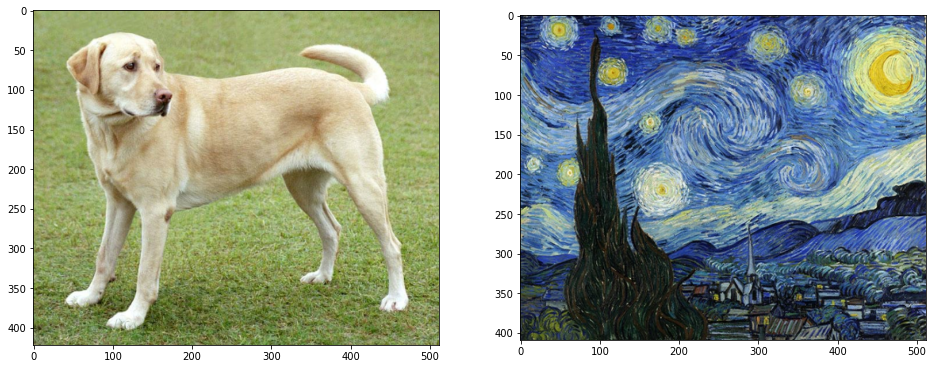

In [ ]:
plt.figure(figsize=[16,32])
plt.subplot(1, 2, 1)
plt.imshow(content_img[0])
plt.subplot(1, 2, 2)
plt.imshow(style_img[0])
plt.show()

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')

574717952/574710816 [==============================] - 4s 0us/step


In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_img*255)
x = tf.image.resize(x, (224, 224))

In [ ]:
prediction = vgg(x)

In [ ]:
pred_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction.numpy(), top=5)[0]

40960/35363 [==================================] - 0s 0us/step


In [ ]:
[(class_name, prob) for (number, class_name, prob) in pred_top_5]

[('Labrador_retriever', 0.49317113),
 ('golden_retriever', 0.23665294),
 ('kuvasz', 0.03635755),
 ('Chesapeake_Bay_retriever', 0.024182769),
 ('Greater_Swiss_Mountain_dog', 0.018646086)]

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

80142336/80134624 [==============================] - 0s 0us/step


In [ ]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [ ]:
style_extractor = vgg_layers(style_layers)

In [ ]:
style_outputs = style_extractor(style_img*255)

In [ ]:
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("\tshape:\t", output.numpy().shape)
    print("\tmin:\t", output.numpy().min())
    print("\tmax:\t", output.numpy().max())
    print("\tmean:\t", output.numpy().mean())
    print()

block1_conv1
	shape:	 (1, 409, 512, 64)
	min:	 0.0
	max:	 764.2899
	mean:	 26.674889

block2_conv1
	shape:	 (1, 204, 256, 128)
	min:	 0.0
	max:	 3434.7927
	mean:	 164.80309

block3_conv1
	shape:	 (1, 102, 128, 256)
	min:	 0.0
	max:	 9059.796
	mean:	 159.9738

block4_conv1
	shape:	 (1, 51, 64, 512)
	min:	 0.0
	max:	 15380.921
	mean:	 595.28174

block5_conv1
	shape:	 (1, 25, 32, 512)
	min:	 0.0
	max:	 4037.115
	mean:	 50.22157



In [ ]:
def gram_matrix(input_tensor):
    # result = tf.linalg.einsum("bijc,bijd->bcd", input_tensor, input_tensor)
    result = tf.squeeze(tf.tensordot(input_tensor, input_tensor, ((1, 2), (1, 2))))
    input_shape = tf.shape(input_tensor)
    num_locs = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/num_locs

In [ ]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super().__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.vgg.trainable = False
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
    
    def call(self, inputs):
        inputs = inputs*255.0
        preprocessed_inp = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_inp)
        style_outputs = outputs[:self.num_style_layers]
        content_outputs = outputs[self.num_style_layers:]
        style_outputs = [gram_matrix(sto) for sto in style_outputs]
        content_dict = {content:value
                        for content, value in zip(self.content_layers, content_outputs)}
        style_dict = {style:value
                        for style, value in zip(self.style_layers, style_outputs)}
        return {'content': content_dict, 'style': style_dict}

In [ ]:
import PIL.Image
def tensor_to_img(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_img))

In [ ]:
style_targets = extractor(style_img)['style']
content_targets = extractor(content_img)['content']

In [ ]:
image = tf.Variable(content_img)

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02)

In [ ]:
style_weight=1e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2) for name in style_outputs.keys()])
    style_loss *= style_weight/num_style_layers
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2) for name in content_outputs.keys()])
    content_loss *= content_weight/num_content_layers
    return style_loss + content_loss

In [ ]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, 0.0, 1.0))

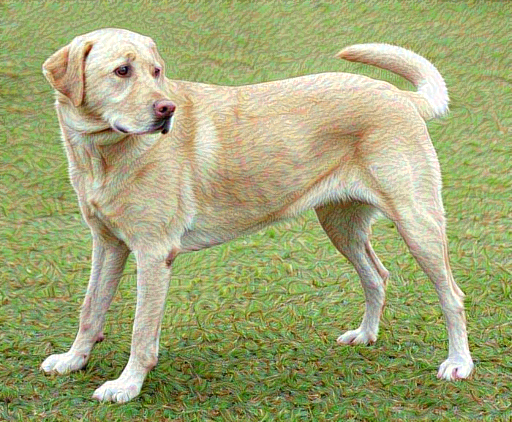

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_img(image)

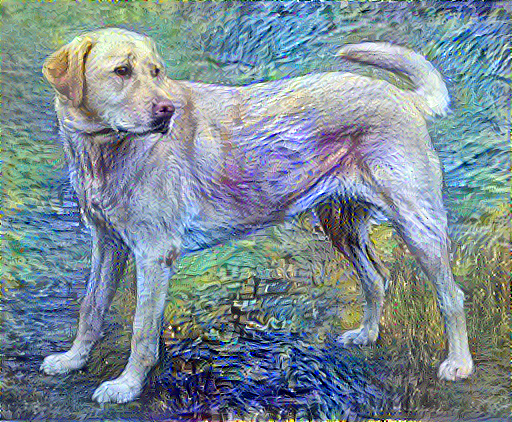

Train step: 1000
Total time: 76.9


In [ ]:
import IPython.display as display
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_img(image))
    print(f"Train step: {step}")
  
end = time.time()
print(f"Total time: {end-start:.1f}")

In [ ]:
def high_pass_x_y(image):
    x_var = image[:,:,1:,:] - image[:,:,:-1,:]
    y_var = image[:,1:,:,:] - image[:,:-1,:,:]
    return x_var, y_var

In [ ]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

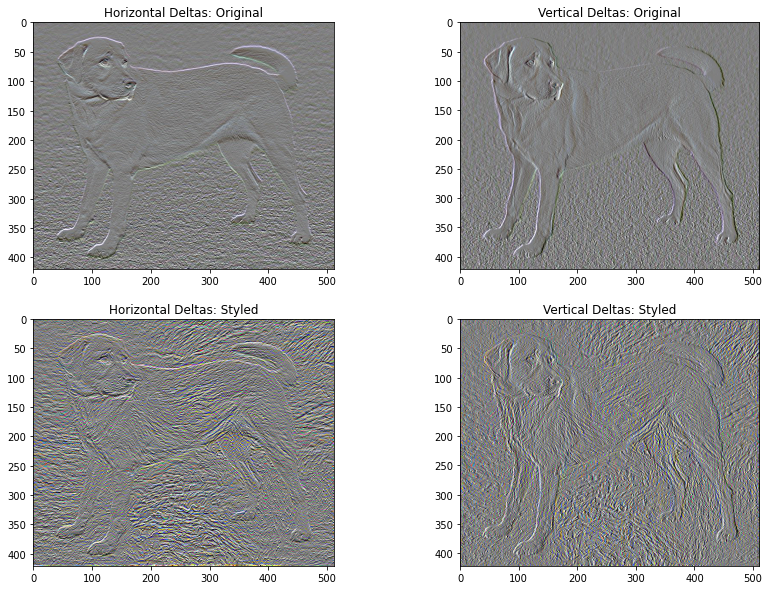

In [ ]:
x_deltas, y_deltas = high_pass_x_y(content_img)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

In [ ]:
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [ ]:
total_variation_loss(image).numpy()

121676.625

In [ ]:
tf.image.total_variation(image).numpy()

array([121676.625], dtype=float32)

In [ ]:
total_variation_weight=30

In [ ]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*tf.image.total_variation(image)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, 0.0, 1.0))

In [ ]:
image = tf.Variable(content_img)

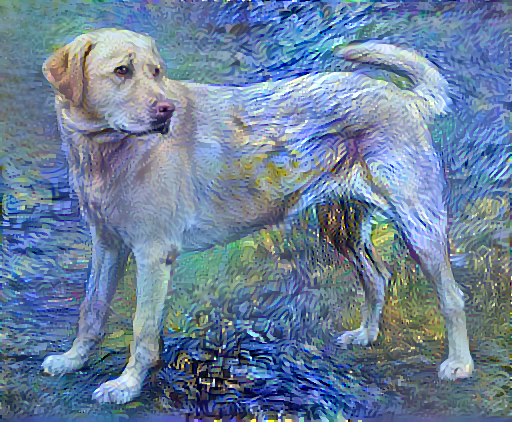

Train step: 1000
Total time: 80.6


In [ ]:
import IPython.display as display
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_img(image))
    print(f"Train step: {step}")
  
end = time.time()
print(f"Total time: {end-start:.1f}")